# FM-G-CAM Paper Code

# Functions

In [1]:
from PIL import Image
import torch
from torch.nn import functional as F
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import matplotlib.pyplot as plt
import numpy as np
import torchinfo

import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import requests

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def get_model_pred_with_grads(model, img_tensor, last_conv_layer, class_count=3):
    
    # TODO: Search for the last convolutional layer
    
    grad_list = []
    act_list = []
    
    for train_param in model.parameters():
        train_param.requires_grad = True
        
    gradients = None
    activations = None

    def hook_backward(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output

    def hook_forward(module, args, output):
        nonlocal activations
        activations = output
        
        
    hook_backward = last_conv_layer.register_full_backward_hook(hook_backward, prepend=False)
    hook_forward = last_conv_layer.register_forward_hook(hook_forward, prepend=False)
    
    model.eval()
    
    preds =  model(img_tensor.to(device).unsqueeze(0))
    
    # Sort prediction indices
    sorted_pred_indices = torch.argsort(preds, dim=1, descending=True).squeeze(0)
    
    # Iterate through the top prediction indices
    for rank in range(class_count):
        preds[:, sorted_pred_indices[rank]].backward(retain_graph=True)
        grad_list.append(gradients)
        act_list.append(activations)
    
    hook_backward.remove()
    hook_forward.remove()
    
    for train_param in model.parameters():
        train_param.requires_grad = False
    
    return preds.squeeze().detach().cpu().numpy(), sorted_pred_indices, grad_list, act_list

In [4]:
def generate_grad_FMCAM(gradients_list, activations_list, class_rank_index=None, enhance=True):
    heatmaps = []
    
    for index, activations in enumerate(activations_list):
        gradients = gradients_list[index]
        
        avg_pooled_gradients = torch.mean(
            gradients[0], # Size [1, 1024, 7, 7]
            dim=[0, 2, 3]
        )

        # Weighting acitvation features (channels) using its related calculated Gradient
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= avg_pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
                
        heatmaps.append(heatmap.unsqueeze(0).detach().cpu())

    if class_rank_index is None:

        # Concatenation of activation maps based on top n classes
        heatmaps = torch.cat(heatmaps)

        # Filter the heatmap based on the maximum weighted activation along the channel axis
        hm_mask_indices = heatmaps.argmax(dim=0).unsqueeze(0)

        hm_3d_mask = torch.cat([hm_mask_indices for _ in range(heatmaps.size()[0])])

        hm_3d_mask = torch.cat(
            [(hm_3d_mask[index] == (torch.ones_like(hm_3d_mask[index])*index)).unsqueeze(0) for index in range(heatmaps.size()[0])]
        ).long()

        heatmaps *= hm_3d_mask

    else:

        heatmaps = heatmaps[class_rank_index]

    
    # L2 Normalisation of the heatmap soften the differences
    if enhance:
        heatmaps = F.normalize(heatmaps, p=2, dim=1)

    # relu on top of the heatmap
    heatmaps = F.relu(heatmaps)
    
    # Min-max normalization of the heatmap
    heatmaps = (heatmaps - torch.min(heatmaps))/(torch.max(heatmaps) - torch.min(heatmaps))
    
    # Process the generated heatmaps

    return heatmaps.detach().cpu().numpy()

In [5]:
def colourise_heatmaps(heatmaps, image_width=224, image_height=224):

    hm_colours = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (0, 1, 1)]
    start_colour = (0, 0, 0)
    
    fused_heatmap_np = None
    
    for i, heatmap in enumerate(heatmaps):
        
        map_colours = [start_colour, hm_colours[i]]

        cmap_tp = LinearSegmentedColormap.from_list("Custom", map_colours, N=256)
        
        if len(heatmaps) == 1:
            cmap_tp = plt.get_cmap('jet')
        
        heatmap_image = Image.fromarray(np.uint8(heatmap*255), 'L').resize((image_width,image_height), resample=Image.BICUBIC)
        heatmap_np = cmap_tp(np.array(heatmap_image))[:, :, :3]
        
        if i == 0:
            fused_heatmap_np = heatmap_np
        else:
            fused_heatmap_np += heatmap_np

    fused_heatmap_np/=np.max(fused_heatmap_np)
            
    fused_heatmap_image = Image.fromarray(np.uint8((fused_heatmap_np * 255)), "RGB")
    
    return fused_heatmap_image

In [6]:
def super_imposed_image(heatmaps, original_image, image_width=224, image_height=224, alpha=0.8):
    
    original_image = original_image.resize((image_width, image_height))
    original_image = Image.blend(original_image, heatmaps.convert("RGB"), alpha=alpha)

    return original_image

In [7]:
def make_prediction(model, img, img_tensor, last_conv_layer, class_count=3, class_rank_index=None, enhance=True, image_width=224, image_height=224, alpha=0.8):
    
    preds, sorted_pred_indices, gradients, activations = get_model_pred_with_grads(
        model, img_tensor, last_conv_layer, class_count=class_count
    )
    heatmaps = generate_grad_FMCAM(gradients, activations, class_rank_index=class_rank_index, enhance=enhance)
    
    heatmaps = colourise_heatmaps(heatmaps)
    
    super_imp_img = super_imposed_image(heatmaps, img, alpha=alpha, image_width=image_width, image_height=image_height)
    
    return preds, sorted_pred_indices, super_imp_img

In [8]:
def show_image_collage(images, w=12, h=5):
    fig, axarr = plt.subplots(1,len(images))
    for i, image in enumerate(images):
        axarr[i].imshow(image)

    # Remove axis labels
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.subplots_adjust(wspace=0)
    fig.set_size_inches(w,h)

# Test 01

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# Model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Model config
# Set model to eval mode
model.eval();
last_conv_layer = model.layer4[2].conv3
class_count = 5
class_list = weights.meta["categories"]
img_h = 224

# Image Preprocessing
url = "https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/cat_dog.png"
r = requests.get(url, allow_redirects=True)
open('dog-and-cat-cover.jpg', 'wb').write(r.content)
img = Image.open("dog-and-cat-cover.jpg")
img = img.resize((img_h,img_h), resample=Image.BICUBIC)
img_tensor = preprocess(img).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [10]:
preds, sorted_pred_indices, super_imp_image = make_prediction(
    model, img, img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=None, enhance=True, image_width=224, image_height=224, alpha=0.8
)
result=dict(zip(
    [class_list[i] for i in sorted_pred_indices[:class_count]],
    np.sort(preds)[::-1][:class_count]
))
print(result)

{'bull mastiff': 6.1618724, 'tabby': 3.5779471, 'boxer': 3.4791768, 'American Staffordshire terrier': 3.340949, 'tiger cat': 3.322522}


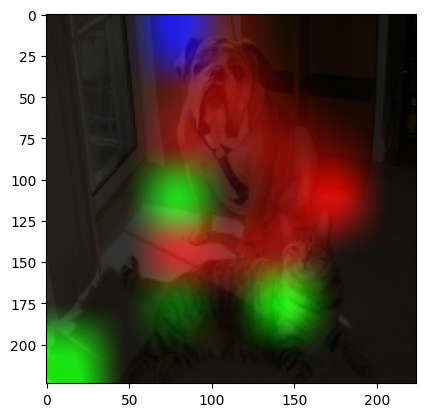

In [11]:
plt.imshow(super_imp_image)

# Test 02

In [12]:
!pip install -q torchxrayvision

In [13]:
import torchxrayvision as xrv
import skimage, torch, torchvision

# Model
model = xrv.models.DenseNet(weights="densenet121-res224-all").to(device)

# Model Configs
# Set model to eval mode
model.eval();
last_conv_layer = model.features.denseblock4.denselayer16.conv2
class_list = model.pathologies
class_count = 4
img_h = 224

# Image Preprocessing
url = "/kaggle/input/ieee8023-covid-chestxray-dataset/ieee covid/AP Supine/1-s2.0-S0735675720302746-gr1_lrg.jpg"
img = skimage.io.imread(url)
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img.mean(2)[None, ...] # Make single color channel

preprocess = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

img = preprocess(img)
img_tensor = torch.from_numpy(img).to(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [14]:
preds, sorted_pred_indices, super_imp_image_0 = make_prediction(
    model, Image.open(url), img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=None, enhance=True, image_width=224, image_height=224, alpha=0.7
)
_, _, super_imp_image_1 = make_prediction(
    model, Image.open(url), img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=0, enhance=True, image_width=224, image_height=224, alpha=0.7
)
_, _, super_imp_image_2 = make_prediction(
    model, Image.open(url), img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=1, enhance=True, image_width=224, image_height=224, alpha=0.7
)
_, _, super_imp_image_3 = make_prediction(
    model, Image.open(url), img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=2, enhance=True, image_width=224, image_height=224, alpha=0.7
)
_, _, super_imp_image_4 = make_prediction(
    model, Image.open(url), img_tensor, last_conv_layer, 
    class_count=class_count, class_rank_index=3, enhance=True, image_width=224, image_height=224, alpha=0.7
)

In [15]:
result=dict(zip(
    [class_list[i] for i in sorted_pred_indices[:class_count]],
    np.sort(preds)[::-1][:class_count]
))
print(result)

{'Lung Opacity': 0.796646, 'Mass': 0.7787188, 'Infiltration': 0.61915517, 'Nodule': 0.6125556}


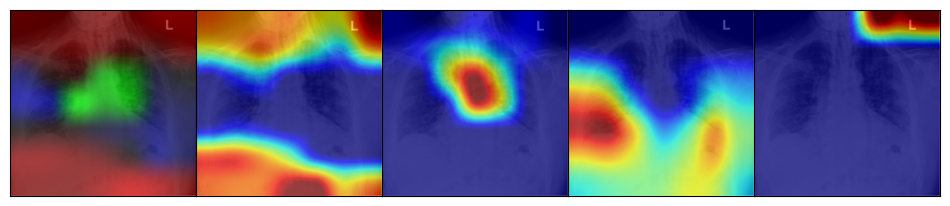

In [16]:
show_image_collage([super_imp_image_0, super_imp_image_1, super_imp_image_2, super_imp_image_3, super_imp_image_4])

In [17]:
# fig, axarr = plt.subplots(1,4)
# axarr[0].imshow(pred_hm_fmgcam)
# axarr[1].imshow(pred_hm_0)
# axarr[2].imshow(pred_hm_1)
# axarr[3].imshow(pred_hm_2)

# # Remove axis labels
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# plt.subplots_adjust(wspace=0)
# fig.set_size_inches(14,6)

In [18]:
# torchinfo.summary(
#     model=model, 
#     input_size=(64, 1, 224, 224),
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"]
# ) 